In [4]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Input
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [5]:
dataset = pd.read_csv('./data/aim_business_cluster_60101020016000109719_train.csv', 
                      names=['collectTime','metrisValue'], index_col='collectTime', 
                      header=0, 
                      parse_dates=['collectTime'])
dataset.head()

,metrisValue
collectTime,
2020-03-14 16:01:00,467.0
2020-03-14 16:11:00,603.0
2020-03-14 16:21:00,615.0
2020-03-14 16:31:00,566.0
2020-03-14 16:41:00,515.0


In [3]:
# resample & fill the nan
single_index_series = dataset['metrisValue'].resample("10T").mean().ffill()

#split the train & test data set
training_set = single_index_series[:'2020/3/22'].values
test_set = single_index_series['2020/3/23':].values

# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set.reshape(-1, 1))

In [11]:
# Generate the train data, which contains the memory step data.
step = 2
cycle = 144
X_train = []
y_train = []
for i in range(cycle,len(training_set_scaled)):
    temp = training_set_scaled[i - step:i, 0]
    temp = np.append(temp, training_set_scaled[i - cycle])
    temp = np.append(temp, training_set_scaled[i - cycle + 1])
    X_train.append(temp)
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [13]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1,)))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=30,batch_size=32)

Epoch 1/30
1056/1056 [==============================] - 4s 4ms/step - loss: 0.0368
Epoch 2/30
1056/1056 [==============================] - 0s 257us/step - loss: 0.0047
Epoch 3/30
1056/1056 [==============================] - 0s 280us/step - loss: 0.0052
Epoch 4/30
1056/1056 [==============================] - 1s 603us/step - loss: 0.0046
Epoch 5/30
1056/1056 [==============================] - 0s 433us/step - loss: 0.0045
Epoch 6/30
1056/1056 [==============================] - 0s 306us/step - loss: 0.0040
Epoch 7/30
1056/1056 [==============================] - 0s 367us/step - loss: 0.0041
Epoch 8/30
1056/1056 [==============================] - 0s 287us/step - loss: 0.0035
Epoch 9/30
1056/1056 [==============================] - 0s 281us/step - loss: 0.0037
Epoch 10/30
1056/1056 [==============================] - 0s 277us/step - loss: 0.0040
Epoch 11/30
1056/1056 [==============================] - 0s 336us/step - loss: 0.0040
Epoch 12/30
1056/1056 [==============================] - 0s 398us

In [49]:
dataset_total = pd.concat((single_index_series[:'2020/3/22'], single_index_series['2020/3/23':]), axis=0)
inputs = dataset_total[len(single_index_series)-len(test_set) - cycle:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)


In [48]:
X_test = []
for i in range(cycle, len(inputs)):
    temp = inputs[i - step:i, 0]
    temp = np.append(temp, inputs[i - cycle])
    temp = np.append(temp, inputs[i - cycle + 1])
    X_test.append(temp)
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_metrisValue = regressor.predict(X_test)
predicted_metrisValue = sc.inverse_transform(predicted_metrisValue)

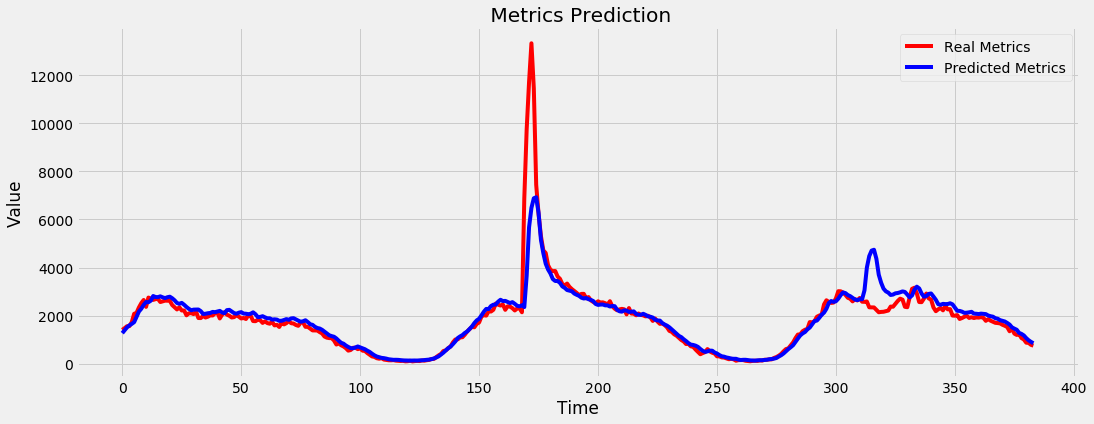

In [20]:
def plot_predictions(test,predicted):
    plt.figure(figsize=(16, 6))
    plt.plot(test, color='red',label='Real Metrics')
    plt.plot(predicted, color='blue',label='Predicted Metrics')
    plt.title(' Metrics Prediction')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
# return_rmse(test_set ,predicted_metrisValue)
plot_predictions(test_set, predicted_metrisValue)

In [50]:
inputs = np.r_[inputs.reshape(-1,), np.zeros(500)].reshape(-1, 1)

In [56]:
for i in range(len(inputs)-500, len(inputs)):
    X_test = []
    temp = inputs[i - 2:i, 0]
    temp = np.append(temp, inputs[i - cycle])
    temp = np.append(temp, inputs[i - cycle + 1])
    X_test.append(temp)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    predicted_metrisValue = regressor.predict(X_test)
    inputs[i][0] = predicted_metrisValue[0][0]
    

[0.21344849 0.20357804 0.18784701 0.15299198]
[0.2161074]
[0.20357804 0.2161074  0.15299198 0.12245527]
[0.20536476]
[0.2161074  0.20536476 0.12245527 0.09315238]
[0.19753632]
[0.20536476 0.19753632 0.09315238 0.10795805]
[0.18578428]
[0.19753632 0.18578428 0.10795805 0.12029611]
[0.18319657]
[0.18578428 0.18319657 0.12029611 0.15916101]
[0.18415523]
[0.18319657 0.18415523 0.15916101 0.12893276]
[0.18859453]
[0.18415523 0.18859453 0.12893276 0.11258482]
[0.1822288]
[0.18859453 0.1822288  0.11258482 0.10240592]
[0.17746633]
[0.1822288  0.17746633 0.10240592 0.06662554]
[0.16739327]
[0.17746633 0.16739327 0.06662554 0.06570019]
[0.1544142]
[0.16739327 0.15441421 0.06570019 0.05243677]
[0.1444847]
[0.15441421 0.1444847  0.05243677 0.04996915]
[0.13281117]
[0.1444847  0.13281117 0.04996915 0.03979025]
[0.12336332]
[0.13281117 0.12336332 0.03979025 0.02899445]
[0.1121994]
[0.12336332 0.1121994  0.02899445 0.03485503]
[0.10301401]
[0.1121994  0.10301401 0.03485503 0.02745219]
[0.09593485]
[0

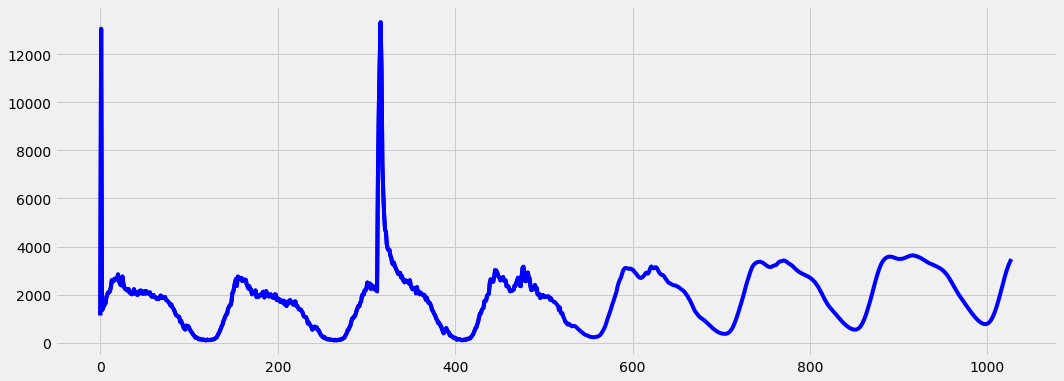

In [62]:
all_inputs = sc.inverse_transform(inputs)
plt.figure(figsize=(16, 6))
plt.plot(all_inputs[:500], color='blue',label='Real&predict Metrics', zorder=2)
plt.plot(all_inputs, color='blue',label='Real&predict Metrics', zorder=1)